In [162]:
import numpy as np
import pandas as pd
import random
from sklearn.metrics import silhouette_score, calinski_harabasz_score, silhouette_score
from scipy.spatial.distance import cdist

# first dataset (utomobile customer segmentation)

In [163]:
auto_data_train = pd.read_csv("train_processed_data.csv")
auto_data_test = pd.read_csv('test_processed_data.csv')
display("Training set", auto_data_train.head())
display(auto_data_train.info())
display("Testing set", auto_data_test.head())  
display(auto_data_test.info())

'Training set'

,Age,Work_Experience,Family_Size,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
0,-1.284623,-0.499892,0.757947,1,0,0,5,2,3,3
1,-0.327151,0.537954,0.096095,0,1,1,2,0,3,0
2,1.408268,-0.499892,-1.227610,0,1,1,2,2,5,1
3,1.408268,-0.805141,-0.565758,1,1,1,7,1,5,1
4,-0.207467,1.453700,2.081652,0,1,1,3,1,5,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              8068 non-null   float64
 1   Work_Experience  8068 non-null   float64
 2   Family_Size      8068 non-null   float64
 3   Gender           8068 non-null   int64  
 4   Ever_Married     8068 non-null   int64  
 5   Graduated        8068 non-null   int64  
 6   Profession       8068 non-null   int64  
 7   Spending_Score   8068 non-null   int64  
 8   Var_1            8068 non-null   int64  
 9   Segmentation     8068 non-null   int64  
dtypes: float64(3), int64(7)
memory usage: 630.4 KB


None

'Testing set'

,Age,Work_Experience,Family_Size,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1
0,-0.450948,-0.792867,-1.196222,0,1,1,2,2,5
1,-0.391999,1.696957,0.767498,1,1,1,5,0,5
2,1.494372,-0.792867,-1.196222,0,1,0,0,2,5
3,0.904881,2.630641,-0.541649,1,1,0,4,1,5
4,-1.453083,-0.045920,0.767498,0,0,0,8,2,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              2627 non-null   float64
 1   Work_Experience  2627 non-null   float64
 2   Family_Size      2627 non-null   float64
 3   Gender           2627 non-null   int64  
 4   Ever_Married     2627 non-null   int64  
 5   Graduated        2627 non-null   int64  
 6   Profession       2627 non-null   int64  
 7   Spending_Score   2627 non-null   int64  
 8   Var_1            2627 non-null   int64  
dtypes: float64(3), int64(6)
memory usage: 184.8 KB


None

In [164]:


import warnings
# Silence warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [165]:
X = auto_data_train.iloc[:, :-1]
X = X.to_numpy()
y_true = auto_data_train.iloc[:, -1] 

# Second Dataset (Mall customer segmentation)

In [166]:
X2 = pd.read_csv('processed_data.csv')
display("Training set", X2.head())
display(X2.info())

'Training set'

,Age,Annual Income (k$),Spending Score (1-100),Gender
0,-1.424569,-1.738999,-0.434801,1
1,-1.281035,-1.738999,1.195704,1
2,-1.352802,-1.700830,-1.715913,0
3,-1.137502,-1.700830,1.040418,0
4,-0.563369,-1.662660,-0.395980,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     200 non-null    float64
 1   Annual Income (k$)      200 non-null    float64
 2   Spending Score (1-100)  200 non-null    float64
 3   Gender                  200 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 6.4 KB


None

In [167]:
X2 = X2.to_numpy()

# Algorithm

In [168]:
def euclidean_distance(x, y):
    return np.linalg.norm(x - y, axis=1)

In [169]:
def compute_inertia(data, labels, centers):
    inertia = 0
    for i, center in enumerate(centers):
        cluster_points = data[labels == i]
        inertia += np.sum((cluster_points - center) ** 2)
    return inertia

In [170]:
# ------------------------------
# Chromosome Class
# ------------------------------

class Chromosome:
    def __init__(self, k_max, dim, data):
        self.k_max = k_max
        self.dim = dim
        self.data = data
        self.thresholds = np.random.rand(k_max)            # thresholds for active/inactive clusters
        self.centers = np.random.rand(k_max, dim) * (np.max(data, axis=0) - np.min(data, axis=0)) + np.min(data, axis=0)    # multiply the centers(vector of k_max * dim shape of [0,1)
                                                                                                                            # by data range to scale and then 
                                                                                                                            # shift by the range by add min

    def get_active_centers(self):
        active_indices = np.where(self.thresholds > 0.5)[0]      # get the active clusters(cneters) that has high threshold
        return self.centers[active_indices], active_indices      # return the centers with its corresponding indeces

    def assign_clusters(self):
        active_centers, active_indices = self.get_active_centers()
        if len(active_centers) < 2:                              # If fewer than 2 clusters are active, reinitialize. We need at least 2 clusters to do clustering. 
            self.reinitialize_centers()
            active_centers, active_indices = self.get_active_centers()

        dists = cdist(self.data, active_centers)                 # we get the distance between centers and data points
                                                                 # dicts ==> Each row represents a data point's distance to each active cluster center ;shape=[n_samples, n_active_clusters]
        labels = np.argmin(dists, axis=1)                        # Assign each point to the closest active center; labels ==> Returns index of the closest center for each point
        for idx in range(len(active_centers)):
            if np.sum(labels == idx) < 2:
                self.reinitialize_centers()
                return self.assign_clusters()                    # recursive ==> try to assign clusters again if at least one active cluster has < 2 points
        return labels, active_centers

    def reinitialize_centers(self):
        indices = np.random.choice(len(self.data), self.k_max, replace=False)       # select k_max random numbers in range len(self.data) without replacement to be indices of centers
        self.centers = self.data[indices]
        self.thresholds = np.random.rand(self.k_max)
        if np.sum(self.thresholds > 0.5) < 2:
            chosen = np.random.choice(self.k_max, 2, replace=False)
            self.thresholds[chosen] = np.random.uniform(0.5, 1.0, size=2)           # Force existing of ar least 2 active clusters

In [171]:
################
#ACDE
################

class ACDE:
    def __init__(self, data, k_max=5, population_size=10, t_max=50):
        self.data = data
        self.k_max = k_max
        self.dim = data.shape[1]
        self.population_size = population_size
        self.t_max = t_max
        self.population = [Chromosome(k_max, self.dim, data) for _ in range(population_size)]
        self.Cr_max = 1.0
        self.Cr_min = 0.5

    def fitness(self, labels):
        if len(np.unique(labels)) < 2:
            return -np.inf
        return calinski_harabasz_score(self.data, labels)

    def mutate(self, target_idx, F):
        indices = [i for i in range(self.population_size) if i != target_idx]
        x1, x2, x3 = np.random.choice(indices, 3, replace=False)
        base, a, b = self.population[x1], self.population[x2], self.population[x3]

        mutant_thresholds = base.thresholds + F * (a.thresholds - b.thresholds)
        mutant_centers = base.centers + F * (a.centers - b.centers)

        mutant_thresholds = np.clip(mutant_thresholds, 0, 1)
        return mutant_thresholds, mutant_centers

    def crossover(self, target, mutant_thresholds, mutant_centers, Cr):
        trial = Chromosome(self.k_max, self.dim, self.data)
        trial.thresholds = np.where(np.random.rand(self.k_max) < Cr, mutant_thresholds, target.thresholds)
        mask = np.random.rand(*target.centers.shape) < Cr
        trial.centers = np.where(mask, mutant_centers, target.centers)
        return trial

    def evolve(self):
        best_fitness = -np.inf
        best_solution = None
        best_labels = None

        for t in range(self.t_max):
            for i in range(self.population_size):
                target = self.population[i]

                # Adaptive F and CR
                F = 0.5 * (1 + np.random.rand())  # Range (0.5, 1)
                Cr = (self.Cr_max - self.Cr_min) * (self.t_max - t) / self.t_max + self.Cr_min

                mutant_thresholds, mutant_centers = self.mutate(i, F)
                trial = self.crossover(target, mutant_thresholds, mutant_centers, Cr)

                try:
                    labels, _ = trial.assign_clusters()
                    score = self.fitness(labels)
                except:
                    score = -np.inf

                target_labels, _ = target.assign_clusters()
                target_score = self.fitness(target_labels)

                if score > target_score:
                    self.population[i] = trial
                    if score > best_fitness:
                        best_fitness = score
                        best_solution = trial.get_active_centers()[0]
                        best_labels = labels
                        
            if best_labels is not None:
                n_clusters = len(np.unique(best_labels))
            else:
                n_clusters = 0

            # print(f"Iter {t+1}/{self.t_max} | Best Fitness: {best_fitness:.4f} | F: {F:.4f} | CR: {Cr:.4f} | Clusters: {n_clusters}")

        inertia = compute_inertia(self.data, best_labels, best_solution)
        silhouette = silhouette_score(self.data, best_labels)
        return best_solution, best_labels, best_fitness, inertia, silhouette

# do the 30 runs on first data

In [172]:
import numpy as np

fitness_list = []
inertia_list = []
silhouette_list = []
num_clusters_list = []

for seed in range(1, 31):
    np.random.seed(seed)  # Set seed for reproducibility
    
    acde = ACDE(X, k_max=10, population_size=10, t_max=100)
    best_solution, best_labels, best_fitness, inertia, silhouette = acde.evolve()
    
    num_clusters = len(np.unique(best_labels))  # Count unique clusters
    
    fitness_list.append(best_fitness)
    inertia_list.append(inertia)
    silhouette_list.append(silhouette)
    num_clusters_list.append(num_clusters)
    
    print(f"Run {seed}: Clusters={num_clusters}, Fitness={best_fitness:.4f}, Inertia={inertia:.4f}, Silhouette={silhouette:.4f}")

print("\n===== Averages over 30 runs =====")
print(f"Average Clusters: {np.mean(num_clusters_list):.2f}")
print(f"Average Fitness: {np.mean(fitness_list):.4f}")
print(f"Average Inertia: {np.mean(inertia_list):.4f}")
print(f"Average Silhouette: {np.mean(silhouette_list):.4f}")


Run 1: Clusters=2, Fitness=5124.3283, Inertia=568210.8426, Silhouette=0.3306
Run 2: Clusters=2, Fitness=5154.2510, Inertia=1911786.4819, Silhouette=0.3426
Run 3: Clusters=2, Fitness=5154.3003, Inertia=207022.7445, Silhouette=0.3426
Run 4: Clusters=2, Fitness=5154.2510, Inertia=353509.4921, Silhouette=0.3426
Run 5: Clusters=2, Fitness=5154.2510, Inertia=105744.5931, Silhouette=0.3426
Run 6: Clusters=2, Fitness=5153.0362, Inertia=14434342.4507, Silhouette=0.3426
Run 7: Clusters=2, Fitness=5154.2510, Inertia=6975786.0561, Silhouette=0.3426
Run 8: Clusters=2, Fitness=5154.2950, Inertia=531620.3036, Silhouette=0.3425
Run 9: Clusters=2, Fitness=5136.3519, Inertia=919475.7188, Silhouette=0.3417
Run 10: Clusters=2, Fitness=5106.2524, Inertia=1994134.6764, Silhouette=0.3374
Run 11: Clusters=2, Fitness=5114.0692, Inertia=1624307.7127, Silhouette=0.3404
Run 12: Clusters=2, Fitness=5154.2510, Inertia=789237.8715, Silhouette=0.3426
Run 13: Clusters=2, Fitness=5121.7245, Inertia=1382644.6980, Silhou

In [173]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# After your 30 runs, assume you have collected metrics in df:
df = pd.DataFrame({
    'run': list(range(1, 31)),
    'clusters': num_clusters_list,
    'inertia': inertia_list,
    'silhouette': silhouette_list,
    'calinski_harabasz': fitness_list,  # Assuming your fitness is Calinski-Harabasz score
})

# Create a copy for scaling
df_scaled = df.copy()

scaler = MinMaxScaler()

# Scale silhouette and calinski_harabasz (maximize)
df_scaled[['silhouette', 'calinski_harabasz']] = scaler.fit_transform(df[['silhouette', 'calinski_harabasz']])

# Scale inertia (minimize) and invert it for maximization
df_scaled['inertia'] = 1 - scaler.fit_transform(df[['inertia']])

# Composite score calculation with weights
df_scaled['composite_score'] = (
    0.4 * df_scaled['inertia'] +
    0.2 * df_scaled['silhouette'] +
    0.4 * df_scaled['calinski_harabasz']
)

# Optional: highlight max composite score row in a Jupyter notebook
df_scaled.style.highlight_max(color='lightgreen', subset=['composite_score'])

# Print the DataFrame with composite scores
print(df_scaled)


    run  clusters       inertia  silhouette  calinski_harabasz  \
0     1         2  9.671564e-01    0.000000           0.400685   
1     2         2  8.734426e-01    0.999577           0.987763   
2     3         2  9.923491e-01    0.999989           0.988731   
3     4         2  9.821317e-01    0.999577           0.987763   
4     5         2  9.994132e-01    0.999577           0.987763   
5     6         2  1.110223e-16    0.996834           0.963929   
6     7         2  5.202309e-01    0.999577           0.987763   
7     8         2  9.697086e-01    0.992860           0.988627   
8     9         2  9.426558e-01    0.919707           0.636587   
9    10         2  8.676988e-01    0.567447           0.046040   
10   11         2  8.934941e-01    0.813996           0.199404   
11   12         2  9.517398e-01    0.999577           0.987763   
12   13         2  9.103500e-01    0.916780           0.349601   
13   14         2  9.883768e-01    0.999577           0.987763   
14   15   

In [174]:
# Identify the best run
best_run_index = df_scaled['composite_score'].idxmax()
best_seed = df.loc[best_run_index, 'run']
print(f"\nBest run is with seed {best_seed}")

# Re-run clustering on the best seed
np.random.seed(best_seed)
acde = ACDE(X, k_max=10, population_size=10, t_max=100)
best_solution, best_labels, best_fitness, inertia, silhouette = acde.evolve()

# Add cluster labels to original data
df_clustered = auto_data_train.copy()
df_clustered['cluster'] = best_labels

# Analyze cluster characteristics
cluster_summary = df_clustered.groupby('cluster').mean(numeric_only=True)
print("\nCluster Summary (means of features):")
print(cluster_summary)

# Optional: show how many customers are in each cluster
print("\nCluster Counts:")
print(df_clustered['cluster'].value_counts())



Best run is with seed 5

Cluster Summary (means of features):
              Age  Work_Experience  Family_Size    Gender  Ever_Married  \
cluster                                                                   
0       -0.021670        -0.024328     0.172255  0.591527      0.504851   
1        0.013465         0.015117    -0.107036  0.520096      0.647508   

         Graduated  Profession  Spending_Score     Var_1  Segmentation  
cluster                                                                 
0         0.467335    5.572122        1.595731  4.118047      1.948254  
1         0.723674    0.991359        1.213424  4.165595      1.321945  

Cluster Counts:
cluster
1    4976
0    3092
Name: count, dtype: int64


In [175]:
import matplotlib.pyplot as plt

def plot_clusters(data, labels, centers, title="Cluster Plot"):
    plt.figure(figsize=(8, 6))
    
    # Plot each cluster with a unique color
    unique_labels = np.unique(labels)
    for label in unique_labels:
        cluster_points = data[labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {label}", s=30)

    # Plot the cluster centers
    if centers is not None:
        plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='X', s=200, label='Centers')

    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid(True)
    plt.show()


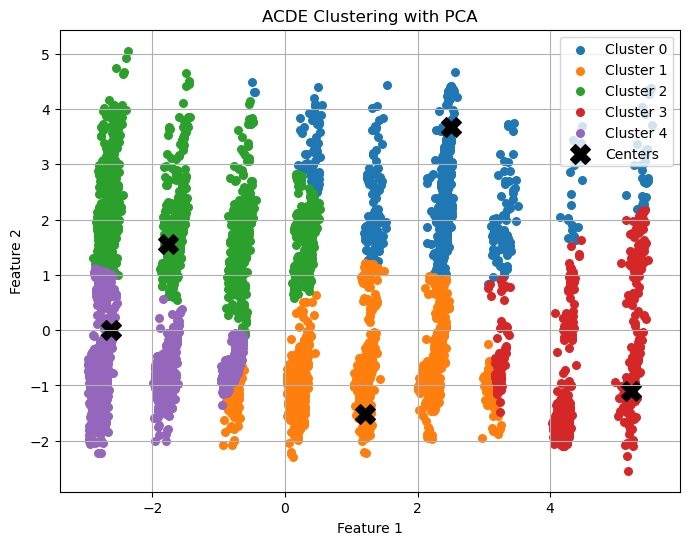

In [176]:
from sklearn.decomposition import PCA

np.random.seed(19)

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Re-run ACDE on the reduced data
acde = ACDE(X_reduced, k_max=10, population_size=10, t_max=100)
best_solution, best_labels, best_fitness, inertia, silhouette = acde.evolve()

#print_acde_results(best_centers, best_labels, best_ch_score, best_sil_score, inertia) # type: ignore
plot_clusters(X_reduced, best_labels, best_solution, title="ACDE Clustering with PCA")


---
---
---


# Do the 30 runs on the second data

In [177]:
import numpy as np

fitness_list = []
inertia_list = []
silhouette_list = []
num_clusters_list = []

for seed in range(1, 31):
    np.random.seed(seed)  # Set seed for reproducibility
    
    acde = ACDE(X2, k_max=10, population_size=10, t_max=100)
    best_solution, best_labels, best_fitness, inertia, silhouette = acde.evolve()
    
    num_clusters = len(np.unique(best_labels))  # Count unique clusters
    
    fitness_list.append(best_fitness)
    inertia_list.append(inertia)
    silhouette_list.append(silhouette)
    num_clusters_list.append(num_clusters)
    
    print(f"Run {seed}: Clusters={num_clusters}, Fitness={best_fitness:.4f}, Inertia={inertia:.4f}, Silhouette={silhouette:.4f}")

print("\n===== Averages over 30 runs =====")
print(f"Average Clusters: {np.mean(num_clusters_list):.2f}")
print(f"Average Fitness: {np.mean(fitness_list):.4f}")
print(f"Average Inertia: {np.mean(inertia_list):.4f}")
print(f"Average Silhouette: {np.mean(silhouette_list):.4f}")


Run 1: Clusters=2, Fitness=95.1605, Inertia=21772.7128, Silhouette=0.3032
Run 2: Clusters=2, Fitness=92.9946, Inertia=1813.8156, Silhouette=0.2992
Run 3: Clusters=2, Fitness=93.7885, Inertia=891.4653, Silhouette=0.3018
Run 4: Clusters=5, Fitness=89.0775, Inertia=350.8551, Silhouette=0.3225
Run 5: Clusters=2, Fitness=94.8283, Inertia=1542.4869, Silhouette=0.3022
Run 6: Clusters=2, Fitness=94.8283, Inertia=2703.5821, Silhouette=0.3022
Run 7: Clusters=2, Fitness=94.6468, Inertia=2050.1122, Silhouette=0.3015
Run 8: Clusters=2, Fitness=94.0994, Inertia=904.6938, Silhouette=0.2993
Run 9: Clusters=5, Fitness=92.1783, Inertia=348.6418, Silhouette=0.3309
Run 10: Clusters=5, Fitness=92.1957, Inertia=304.6413, Silhouette=0.3409
Run 11: Clusters=2, Fitness=94.0864, Inertia=7366.9621, Silhouette=0.3021
Run 12: Clusters=2, Fitness=93.9262, Inertia=664.9573, Silhouette=0.2990
Run 13: Clusters=2, Fitness=93.8631, Inertia=21251.8804, Silhouette=0.3011
Run 14: Clusters=4, Fitness=94.8970, Inertia=389.18

In [178]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# After your 30 runs, assume you have collected metrics in df:
df = pd.DataFrame({
    'run': list(range(1, 31)),
    'clusters': num_clusters_list,
    'inertia': inertia_list,
    'silhouette': silhouette_list,
    'calinski_harabasz': fitness_list,  # Assuming your fitness is Calinski-Harabasz score
})

# Create a copy for scaling
df_scaled = df.copy()

scaler = MinMaxScaler()

# Scale silhouette and calinski_harabasz (maximize)
df_scaled[['silhouette', 'calinski_harabasz']] = scaler.fit_transform(df[['silhouette', 'calinski_harabasz']])

# Scale inertia (minimize) and invert it for maximization
df_scaled['inertia'] = 1 - scaler.fit_transform(df[['inertia']])

# Composite score calculation with weights
df_scaled['composite_score'] = (
    0.4 * df_scaled['inertia'] +
    0.2 * df_scaled['silhouette'] +
    0.4 * df_scaled['calinski_harabasz']
)

# Optional: highlight max composite score row in a Jupyter notebook
df_scaled.style.highlight_max(color='lightgreen', subset=['composite_score'])

# Print the DataFrame with composite scores
print(df_scaled)


    run  clusters   inertia  silhouette  calinski_harabasz  composite_score
0     1         2  0.649926    0.118288           0.648912         0.543193
1     2         2  0.975390    0.034981           0.435008         0.571156
2     3         2  0.990431    0.090263           0.513419         0.619592
3     4         5  0.999246    0.519594           0.048157         0.522880
4     5         2  0.979815    0.097903           0.616103         0.657948
5     6         2  0.960881    0.097903           0.616103         0.650374
6     7         2  0.971537    0.083100           0.598180         0.644507
7     8         2  0.990215    0.036520           0.544124         0.621040
8     9         5  0.999282    0.693769           0.354388         0.680222
9    10         5  1.000000    0.900710           0.356108         0.722585
10   11         2  0.884837    0.095679           0.542836         0.590205
11   12         2  0.994124    0.031826           0.527016         0.614821
12   13     

In [179]:
# Identify the best run
best_run_index = df_scaled['composite_score'].idxmax()
best_seed = df.loc[best_run_index, 'run']
print(f"\nBest run is with seed {best_seed}")

# Re-run clustering on the best seed
np.random.seed(best_seed)
acde = ACDE(X, k_max=10, population_size=10, t_max=100)
best_solution, best_labels, best_fitness, inertia, silhouette = acde.evolve()

# Add cluster labels to original data
df_clustered = auto_data_train.copy()
df_clustered['cluster'] = best_labels

# Analyze cluster characteristics
cluster_summary = df_clustered.groupby('cluster').mean(numeric_only=True)
print("\nCluster Summary (means of features):")
print(cluster_summary)

# Optional: show how many customers are in each cluster
print("\nCluster Counts:")
print(df_clustered['cluster'].value_counts())



Best run is with seed 21

Cluster Summary (means of features):
              Age  Work_Experience  Family_Size    Gender  Ever_Married  \
cluster                                                                   
0        0.006193         0.002736    -0.133139  0.516136      0.643165   
1       -0.009407        -0.004156     0.202223  0.595067      0.516391   

         Graduated  Profession  Spending_Score     Var_1  Segmentation  
cluster                                                                 
0         0.726619    0.945529        1.230216  4.193628      1.323124  
1         0.471745    5.482985        1.556978  4.077115      1.924758  

Cluster Counts:
cluster
0    4865
1    3203
Name: count, dtype: int64


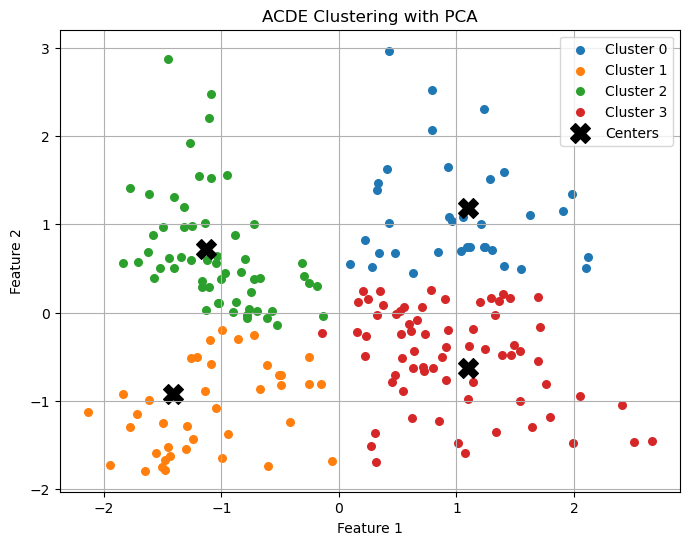

In [180]:
from sklearn.decomposition import PCA

np.random.seed(21)

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X2)

# Re-run ACDE on the reduced data
acde = ACDE(X_reduced, k_max=10, population_size=10, t_max=100)
best_solution, best_labels, best_fitness, inertia, silhouette = acde.evolve()

#print_acde_results(best_centers, best_labels, best_ch_score, best_sil_score, inertia) # type: ignore
plot_clusters(X_reduced, best_labels, best_solution, title="ACDE Clustering with PCA")


test your Adaptive Clustering using Differential Evolution (ACDE) algorithm on blob data

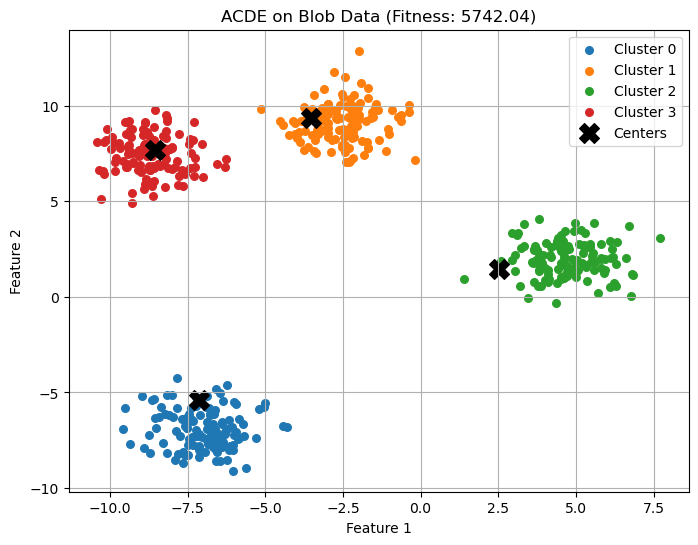

In [181]:
from sklearn.datasets import make_blobs

# Generate synthetic data
X, y_true = make_blobs(n_samples=500, centers=4, cluster_std=1.0, random_state=42)



np.random.seed(19)
acde = ACDE(X, k_max=10, population_size=10, t_max=100)
best_solution, best_labels, best_fitness, inertia, silhouette = acde.evolve()


plot_clusters(X, best_labels, best_solution, title=f"ACDE on Blob Data (Fitness: {best_fitness:.2f})")


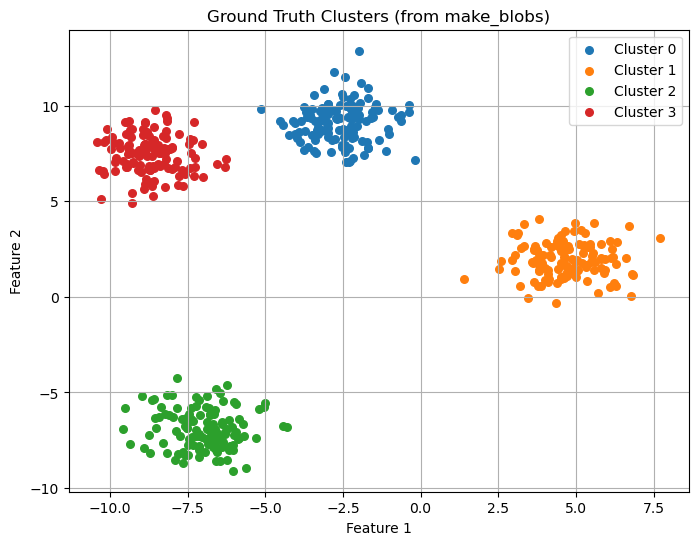

In [182]:
plot_clusters(X, y_true, None, title="Ground Truth Clusters (from make_blobs)")
